First step is to import the required libraries.

In [1]:
import pandas as pd
import numpy as np

import json
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

# import distance for cdist analysis
from scipy.spatial import distance

!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Complete')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  55.58 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  35.43 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  40.34 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  49.31 MB/s
Complete


Since this is a ‘Battle of the Neighborhoods’ assignment, an important step is to define neighborhoods with location.
I used the official list from Wikipedia for the neighborhoods.  There was some manual clean-up required to align with the geopy
module, so here is the final simple list of neighborhoods that works for the project:

In [2]:
den_neigh = ['Auraria', 'Belcaro', 'Washington Park', 'Washington Park West', 'Speer', 'Cherry Creek', 'Country Club', 
         'Congress Park', 'City Park', 'Marston', 'Fort Logan', 'Virginia Vale', 'Barnum', 'Barnum West', 'West Colfax', 
         'West Highland', 'Sloan Lake', 'Berkeley', 'Regis', 'Chaffee Park', 'Highland', 'Athmar Park', 'Windsor', 'Wellshire', 
         'University', 'Rosedale', 'Cheesman Park', 'Hilltop', 'Montclair', 'Hale', 'North Park Hill', 'South Park Hill', 
         'University Park', 'Platt Park', 'Overland', 'Ruby Hill', 'Kennedy', 'Hampden', 'Southmoor Park', 'Indian Creek', 
         'Goldsmith', 'Virginia Village', 'University Hills', 'Harvey Park', 'Mar Lee', 'East Colfax', 'Capitol Hill', 
         'North Capitol Hill', 'Civic Center', 'CBD', 'Union Station', 'Stapleton', 'Montbello', 'Lowry', 'Green Valley Ranch', 
         'Harvey Park South', 'College View', 'City Park West', 'Sun Valley', 'Valverde', 'Villa Park', 'Five Points', 
         'Globeville', 'Bear Valley', 'Jefferson Park', 'Park Hill', 'Elyria Swansea', 'Baker', 'Clayton', 'Skyland', 
         'Lincoln Park', 'Whittier', 'Cole', 'Westwood', 'Sunnyside', 'DIA']

This loop puts the latitude and longitude in place for every neighborhood, since we need location to find proximity later.
The results are put into a data frame.

In [3]:
den_neigh_ll = []
for neigh in den_neigh:
    address = '{}, Denver, CO, USA'.format(neigh)
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    if location is None:
        lat = 'N/A'
        long = 'N/A'
    else:
        lat = location.latitude
        long = location.longitude
    den_neigh_ll.append((neigh, lat, long))
    
den_neigh_df = pd.DataFrame(den_neigh_ll, columns=('Neighborhood', 'Lat', 'Long'))
den_neigh_df.sort_values(by='Neighborhood').head()

,Neighborhood,Lat,Long
21,Athmar Park,39.703682,-105.010741
0,Auraria,39.746522,-105.006710
67,Baker,39.711594,-104.993750
12,Barnum,39.717683,-105.032455
13,Barnum West,39.717155,-105.046497


This just gives us the center of Denver, so the folium map has a reference point.

In [4]:
#Denver center
address = 'Denver, CO, USA'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Denver are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Denver are 39.7392364, -104.9848623.


The below cells are the variables and the function to find the nearest breweries based on the neighborhood location.
I found results and location by using my Foursquare API to connect to their database.  Notice the keyword is 'brew' 
for brewery, brewing co, brewhouse, etc.  All the results are returned into a data frame that ties the neighborhood 
with location, to the brewery (also with location).

In [5]:
VERSION = '20190228'
LIMIT = 10
search_query = 'brew'

In [6]:
def getBreweries(names, latitudes, longitudes, radius=3000):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            lat,
            lng,
            VERSION,
            search_query,
            radius,
            LIMIT)
        results = requests.get(url).json()["response"]['venues']
        venues_list.append([(
            name,
            lat,
            lng,
            v['name'],
            v['location']['lat'],
            v['location']['lng']) for v in results])
    breweries = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    breweries.columns = ['Neighborhood',
                  'Neighborhood Latitude',
                  'Neighborhood Longitude',
                  'Venue',
                  'Venue Latitude',
                  'Venue Longitude']
    return(breweries)

Below I made another data frame by using the columns from the earlier data frame columns as args for the getBreweries function.

In [7]:
den_brew_df = getBreweries(names=den_neigh_df['Neighborhood'],
                        latitudes=den_neigh_df['Lat'],
                        longitudes=den_neigh_df['Long'])
den_brew_df.shape

(580, 6)

Since there would be duplicate breweries returned in this method (i.e. a short distance between some smaller neighborhoods), I de-duplicated the results in the data frame.

In [8]:
den_brew_df['dupe'] = den_brew_df.duplicated(subset=['Venue','Venue Latitude','Venue Longitude'], keep='first')
den_brew_df2 = den_brew_df[den_brew_df.dupe==False]
den_brew_df2.shape

(152, 7)

I then used the folium module to show both the neighborhood central points as well as breweries on the same map.
This map alone is a useful visual to see where breweries are clustered together and where they are sparser, so a 
lot of information could be gained by just looking here.

In [15]:
#create map of Denver using latitude and longitude values
map_denver = folium.Map(location=[latitude, longitude], zoom_start=12)

#add neighborhoods to map
for lat, lng, label in zip(den_neigh_df['Lat'], den_neigh_df['Long'], den_neigh_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_denver)  

# add breweries as green circle markers
for lat2, lng2 in zip(den_brew_df2['Venue Latitude'],den_brew_df2['Venue Longitude']):
    folium.features.CircleMarker(
        [lat2, lng2],
        radius=2,
        color='green',
        fill = True,
        fill_color='green',
        fill_opacity=0.6).add_to(map_denver)
    
map_denver

I can't get this map to load on github as part of the notebook for some reason.  Here is the link to the image, sorry:
https://github.com/mtnbike14/Coursera_Capstone/blob/master/original_map.jpg

I iterated over the rows in the data frame to create a dictionary with neighborhoods as keys and location as values.
I also took out the brewery locations as a list of tuples so I could compare both of these for distance.

In [10]:
W = []
X = []
Z = []
for i,row in den_brew_df2.iterrows():
    a = (row[1],row[2])
    b = (row[4],row[5])
    Z.append(b)
    if a in X:
        continue
    else:
        W.append(row[0])
        X.append(a)

neigh_dict = dict(zip(W,X))

I used the cdist function in the distance module in the SciPy library to analyze what we are seeing.  This function lets us tie in the business problem. By using the neighborhood points as the starting set, we can look at brewery points as reference with a cut-off distance and see what breweries are close to each neighborhood center.  Then, by counting those values for each neighborhood, we get a good summary of how many breweries are close to each neighborhood center in a final data frame.

In [11]:
lst = []
for k,v in neigh_dict.items():
    m = (distance.cdist([neigh_dict[k]],Z).min())
    s = np.where(distance.cdist([neigh_dict[k]],Z) <= 0.02)
    s2 = len(np.unique(s))
    lst.append([k, m, s2])

cols = ['Neighborhood','Closest Distance','Breweries in cutoff']
final_df = pd.DataFrame(lst,columns=cols)
final_df.sort_values(by=['Breweries in cutoff','Neighborhood']).set_index('Neighborhood')

,Closest Distance,Breweries in cutoff
Neighborhood,,
Barnum West,0.025735,0
Country Club,0.033741,0
Elyria Swansea,0.021024,0
Goldsmith,0.027942,0
Green Valley Ranch,0.032133,0
Marston,0.020039,0
Montbello,0.022391,0
Overland,0.024435,0
University Park,0.022091,0


Finally, I made a quick histogram of the last data frame.  I wanted to see how the brewery numbers are distributed.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45d07f3470>]], dtype=object)

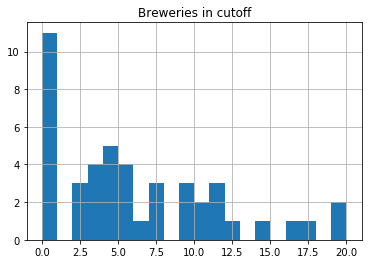

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

final_df.hist(column='Breweries in cutoff',bins=20)